In [1]:
# Common Libraries
import pandas as pd
from pandas_datareader import data
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Sci Kit Learn Models
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

# Sci Kit Learn Reporting
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Tensor Flow Models
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Keras Classifier model
from keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

# Bar Graphic
from tqdm import tqdm

## MODELLING

### Train-Test Split

In this first part of the modelling, the data are split with a test size of 20% and have a stratification on the dependent variable "buy_ignore"  

In [2]:
# Importing data produced with BuildData
DATA_ML = pd.read_csv('DATA_ML.csv')
DATA_ML = DATA_ML.set_index('symbol')

In [3]:
# Divide data in train and testing
train_split, test_split = train_test_split(DATA_ML, test_size=0.2, random_state=1, stratify=DATA_ML['buy_ignore'])
X_train = train_split.iloc[:, :-1]
y_train = train_split.iloc[:, -1]
X_test = test_split.iloc[:, :-1]
y_test = test_split.iloc[:, -1]

### Logistic Regression

The Logistic Regression is the first model to be tested. A manual optimization is investigated by changing the strenght of the regularization. The scores are printed out

In [4]:
lr = LogisticRegression(max_iter=1000)
lr = lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6482300884955752

In [5]:
# Changed the strength of regularization from default 1 to 10
lr = LogisticRegression(C=10.0)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.6504424778761062

The predictions, the probabilites of the test elements of being 1 and the confusion matrix are saved

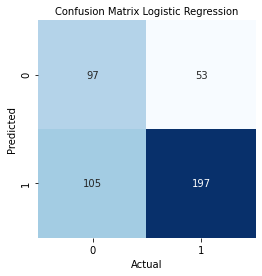

In [6]:
y_prob_lr = lr.predict_proba(X_test)[:,1] # Probability of 1s for each element of the testing Data
y_pred_lr = lr.predict(X_test) # Predictions
lr_conf_matrix = confusion_matrix(y_test, y_pred_lr)

#Confusion Matrix Plot
plt.subplots(figsize = (8,4))
sns.heatmap(lr_conf_matrix.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('Actual',fontsize=10)
plt.ylabel('Predicted',fontsize=10)
plt.title('Confusion Matrix Logistic Regression',fontsize=10);

In [7]:
# Function for plotting probabilities of being 1 for 0s and 1s of the testing Data
def plot_prob_1s(prob):
    plt.figure(figsize=(8,4))
    plt.hist(prob[y_test==0], bins=80, label='0', color='blue')
    plt.hist(prob[y_test==1], bins=80, label='1', alpha=0.7, color='red')
    plt.xlabel('Probability', fontsize=10)
    plt.ylabel('Number of observations', fontsize=10)
    plt.title('Probability of Being 1',fontsize=10);
    plt.legend(fontsize=8)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 

The following plot shows the probability of the testing elements of being 1

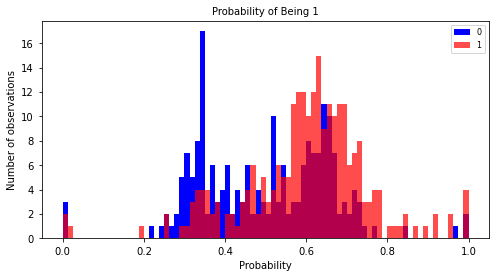

In [8]:
plot_prob_1s(y_prob_lr)

In [9]:
# Classification Report Logistic Regression
print(classification_report(y_test,y_pred_lr,target_names=['IGNORE', 'BUY']))

              precision    recall  f1-score   support

      IGNORE       0.65      0.48      0.55       202
         BUY       0.65      0.79      0.71       250

    accuracy                           0.65       452
   macro avg       0.65      0.63      0.63       452
weighted avg       0.65      0.65      0.64       452



The top 5 coefficients of the regression are printed below

In [10]:
# Extract the coefficients of the logistic regression estimator
lr.coef_[0]

# Create a dataframe of the variables and coefficients
coef_df = pd.DataFrame({"Variable" : X_train.columns, "Coefficient": lr.coef_[0]})
coef_df = coef_df.set_index('Variable')

# Print out the top 5 positive variables
top_five_coef = coef_df.sort_values(by="Coefficient", axis=0, ascending=False)[0:5]
top_five_coef

,Coefficient
Variable,
dividendPayoutRatio,2.478176
Total assets,2.461998
Net Income per Share,1.170248
Revenue per Share,0.887690
Gross Profit Growth,0.814953


### Random Forest Classifier

The ensemble Random Forest Classifier is the second model analysed. Score and confusion matrix pre-optimization are printed below as well as the top paramenter of the first tree

In [11]:
rfc = RandomForestClassifier(max_depth=4, criterion='gini', n_estimators=10)
rfc = rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test) # Predictions
rfc_conf_matrix = confusion_matrix(y_test, y_pred_rfc) # Confusion Matrix

#Print Predictions and Confusion Matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rfc))
print("\nAccuracy Score: \n", accuracy_score(y_test, y_pred_rfc))

Confusion Matrix: 
 [[ 84 118]
 [ 35 215]]

Accuracy Score: 
 0.661504424778761


In [12]:
# Extract the 1st tree from the random forest, and then the top parameter
chosen_tree = rfc.estimators_[0]
split_column = chosen_tree.tree_.feature[0]
split_column_name = X_train.columns[split_column]
split_column_name

'Earnings Yield'

A GridSearch cross validator is then used to optimize the model. The probability of being 1 of the testing element, the predictions and the confusion matrix emanating from the best estimator are shown

In [13]:
# Set Parameters for Grid Search
rfc_parameters = {'n_estimators': [8, 32, 64, 128],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [4, 5, 6, 7, 8],
              'criterion': ['gini', 'entropy']}

# GridSearch
rfc = GridSearchCV(RandomForestClassifier(random_state=1),
                    rfc_parameters,
                    n_jobs=6,
                    scoring='accuracy',
                    cv=5,
                    return_train_score=True)

rfc.fit(X_train, y_train);

In [14]:
y_prob_rfc = rfc.best_estimator_.predict_proba(X_test)[:,1] # Probability of 1s for each element of the testing Data Best Estimator
y_pred_rfc = rfc.best_estimator_.predict(X_test) # Predictions Best Estimator
rfc_conf_matrix = confusion_matrix(y_test, y_pred_rfc) # Confusion Matrix Best Estimator

#Print Predictions and Confusion Matrix Best Estimator
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rfc))
print("\nAccuracy Score: \n", accuracy_score(y_test, y_pred_rfc))

Confusion Matrix: 
 [[109  93]
 [ 45 205]]

Accuracy Score: 
 0.6946902654867256


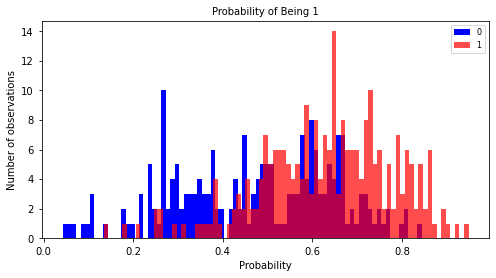

In [15]:
plot_prob_1s(y_prob_rfc)

In [16]:
# Classification Report Random Forest Classifier
print(classification_report(y_test,y_pred_rfc,target_names=['IGNORE', 'BUY']))

              precision    recall  f1-score   support

      IGNORE       0.71      0.54      0.61       202
         BUY       0.69      0.82      0.75       250

    accuracy                           0.69       452
   macro avg       0.70      0.68      0.68       452
weighted avg       0.70      0.69      0.69       452



In [17]:
rfc_df = pd.DataFrame(rfc.cv_results_)

The plot below shows the score means and standard deviations of the training and testing data separately

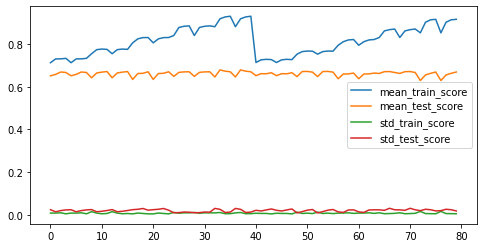

In [18]:
rfc_scores = rfc_df[['mean_train_score','mean_test_score','std_train_score','std_test_score']]
rfc_scores.plot(figsize=(8, 4));

This other plot shows the scores of the training and the testing data split by the GridSearch parameters. To build up the volatility bands, the pooled variance is used rather than the simple one

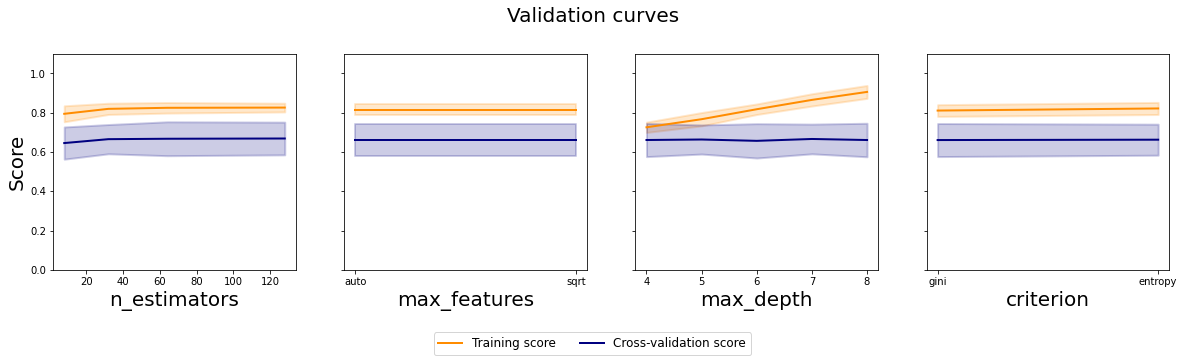

In [19]:
results = ['mean_test_score',
           'mean_train_score',
           'std_test_score', 
           'std_train_score']

def pooled_var(stds):
    n = 5 # size of each group
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

fig, axes = plt.subplots(1, len(rfc_parameters), 
                         figsize = (5*len(rfc_parameters), 5),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=20)


for idx, (param_name, param_range) in enumerate(rfc_parameters.items()):
    grouped_df = rfc_df.groupby(f'param_{param_name}')[results]\
        .agg({'mean_train_score': 'mean',
              'mean_test_score': 'mean',
              'std_train_score': pooled_var,
              'std_test_score': pooled_var})

    previous_group = rfc_df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=20)
    axes[idx].set_ylim(0.0, 1.1)
    lw = 2
    axes[idx].plot(param_range, grouped_df['mean_train_score'], label="Training score",
                color="darkorange", lw=lw)
    axes[idx].fill_between(param_range,grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                    color="darkorange", lw=lw)
    axes[idx].plot(param_range, grouped_df['mean_test_score'], label="Cross-validation score",
                color="navy", lw=lw)
    axes[idx].fill_between(param_range, grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                    grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                    color="navy", lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=20)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=12)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()

In [20]:
# Best Estimators Parameters
best_n_estimators = rfc.best_params_
best_n_estimators

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 32}

In [21]:
# Final Random Forest Classifier Model
rfc = RandomForestClassifier(max_depth=8, criterion='gini', n_estimators=32,max_features='auto')
rfc = rfc.fit(X_train, y_train)

### Support Vector Machine

Another algorithm analysed is the Support Vector Machine. The optimization method used is the RandomSearch on the Cs and Gammas parameters

In [22]:
svc = SVC()
svc = svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test) # Predictions
svc_conf_matrix = confusion_matrix(y_test, y_pred_svc) # Confusion Matrix

#Print Predictions and Confusion Matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_svc))
print("\nAccuracy Score: \n", accuracy_score(y_test, y_pred_svc))

Confusion Matrix: 
 [[ 83 119]
 [ 44 206]]

Accuracy Score: 
 0.6393805309734514


In [23]:
# Create the parameter grid
Cs = stats.uniform(2, 10)
Gammas = stats.uniform(0.1, 1)

svc_parameters = {"C": Cs,
             "gamma": Gammas}

# Create a random search object
svc = RandomizedSearchCV(
    estimator = SVC(probability=True),
    param_distributions = svc_parameters,
    n_iter = 80,
    scoring='accuracy', n_jobs=4, cv = 5, refit=True, return_train_score = True)

# Fit to the training data
svc.fit(X_train, y_train);

In [24]:
y_prob_svc = svc.best_estimator_.predict_proba(X_test)[:,1] # Probability of 1s for each element of the testing Data Best Estimator
y_pred_svc = svc.best_estimator_.predict(X_test) # Predictions Best Estimator
svc_conf_matrix = confusion_matrix(y_test, y_pred_svc) # Confusion Matrix Best Estimator

#Print Predictions and Confusion Matrix Best Estimator
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_svc))
print("\nAccuracy Score: \n", accuracy_score(y_test, y_pred_svc))

Confusion Matrix: 
 [[ 85 117]
 [ 40 210]]

Accuracy Score: 
 0.6526548672566371


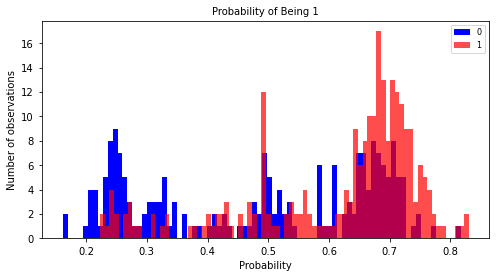

In [25]:
plot_prob_1s(y_prob_svc)

In [26]:
# Classification Report Support Vector Classifier
print(classification_report(y_test,y_pred_svc,target_names=['IGNORE', 'BUY']))

              precision    recall  f1-score   support

      IGNORE       0.68      0.42      0.52       202
         BUY       0.64      0.84      0.73       250

    accuracy                           0.65       452
   macro avg       0.66      0.63      0.62       452
weighted avg       0.66      0.65      0.63       452



In [27]:
svc_df = pd.DataFrame(svc.cv_results_)

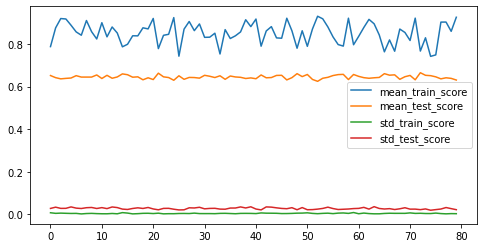

In [28]:
svc_scores = svc_df[['mean_train_score','mean_test_score','std_train_score','std_test_score']]
svc_scores.plot(figsize=(8, 4));

The scatter plot below shows the testing score by the two parameters randomly searched with the cross-validator

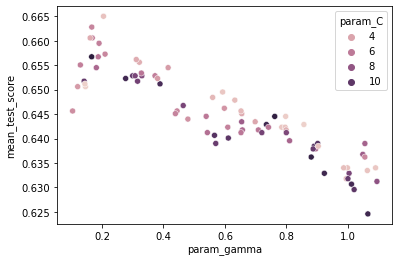

In [29]:
# Plotting Scores by Cs and Gammas for Testing Scores
sns.scatterplot(data=svc_df, x='param_gamma', y='mean_test_score', hue='param_C');

In [30]:
# Best Estimators Parameters
best_n_estimators = svc.best_params_
best_n_estimators

{'C': 2.708836387615628, 'gamma': 0.20472548623989997}

In [31]:
# Final Support Classifier Model
svc = SVC(C=2.70, gamma=0.20)
svc = svc.fit(X_train, y_train)

### Keras Classifier

Another model used is the Keras Classifier belonging to the family of the Neural Networks algorithms. 
Two hidden layers have been added and a GridSearch cross validation is executed on the batch size and the epochs

In [32]:
# Function to create model, required for KerasClassifier
def create_model():
# create model
    model = Sequential()
    model.add(Dense(12, input_dim=61, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
# Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
# create model
kc = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

kc_parameters = dict(batch_size=batch_size, epochs=epochs)
kc = GridSearchCV(estimator=kc, param_grid=kc_parameters, n_jobs=-1, cv=3, return_train_score=True)
kc = kc.fit(X_train, y_train)

In [34]:
y_prob_kc = kc.best_estimator_.predict_proba(X_test)[:,1] # Probability of 1s for each element of the testing Data Best Estimator
y_pred_kc = kc.best_estimator_.predict([X_test]) # Predictions Best Estimator
kc_conf_matrix = confusion_matrix(y_test, y_pred_kc) # Confusion Matrix Best Estimator

#Print Predictions and Confusion Matrix Best Estimator
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_kc))
print("\nAccuracy Score: \n", accuracy_score(y_test, y_pred_kc))

Confusion Matrix: 
 [[101 101]
 [ 51 199]]

Accuracy Score: 
 0.6637168141592921


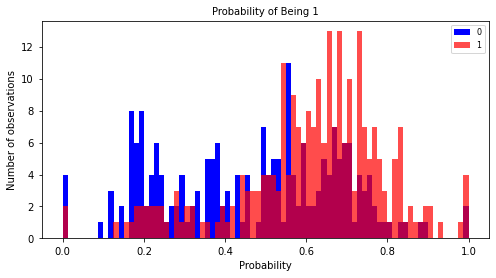

In [35]:
plot_prob_1s(y_prob_kc)

In [36]:
# Classification Report Keras Classifier
print(classification_report(y_test,y_pred_kc,target_names=['IGNORE', 'BUY']))

              precision    recall  f1-score   support

      IGNORE       0.66      0.50      0.57       202
         BUY       0.66      0.80      0.72       250

    accuracy                           0.66       452
   macro avg       0.66      0.65      0.65       452
weighted avg       0.66      0.66      0.66       452



In [37]:
kc_df = pd.DataFrame(kc.cv_results_)

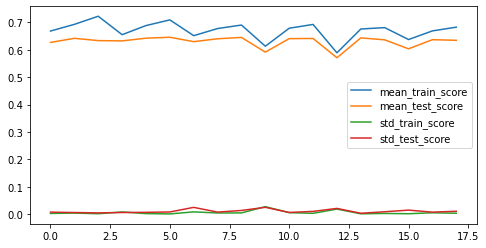

In [38]:
kc_scores = kc_df[['mean_train_score','mean_test_score','std_train_score','std_test_score']]
kc_scores.plot(figsize=(8, 4));

The line plot below shows the testing score by the two parameters searched with the grid

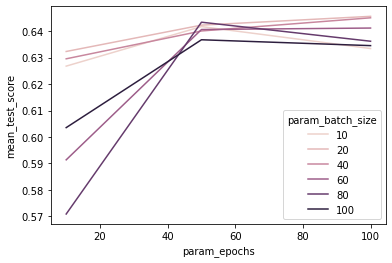

In [39]:
# Plotting Scores by Cs and Gammas for Testing Data
sns.lineplot(data=kc_df, x='param_epochs', y='mean_test_score', hue='param_batch_size');

In [40]:
# Best Estimators Parameters
best_n_estimators = kc.best_params_
best_n_estimators

{'batch_size': 20, 'epochs': 100}

In [41]:
# Final keras Classifier Model
kc = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)
kc.fit(X_train, y_train);

### Stacking Model

The last model is a stacking of the optimized models tested so far (Logistic Regression, Support Vector and Random Forest)

In [42]:
# get a stacking ensemble of models
def get_stacking():
# define the base models
    level0 = list()
    level0.append(('lr', lr))
    level0.append(('svc', svc))
    level0.append(('rfc', rfc))
    # define meta learner model
    level1 = lr
    # define the stacking ensemble
    stacking = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return stacking

In [43]:
stacking = get_stacking()
stacking = stacking.fit(X_train, y_train)

In [44]:
y_prob_stacking = stacking.predict_proba(X_test)[:,1] # Probability of 1s for each element of the testing Data
y_pred_stacking = stacking.predict(X_test) # Predictions
stacking_conf_matrix = confusion_matrix(y_test, y_pred_stacking)

#Print Predictions and Confusion Matrix Best Estimator
print("Confusion Matrix: \n", stacking_conf_matrix)
print("\nAccuracy Score: \n", accuracy_score(y_test, y_pred_stacking))

Confusion Matrix: 
 [[104  98]
 [ 41 209]]

Accuracy Score: 
 0.6924778761061947


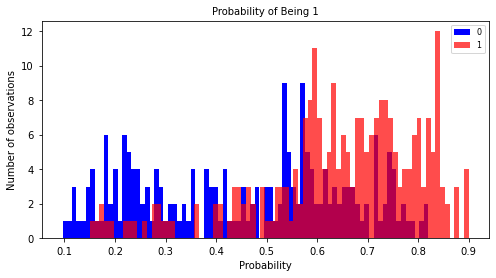

In [45]:
plot_prob_1s(y_prob_stacking)

In [46]:
# Classification Report Stacking
print(classification_report(y_test,y_pred_stacking,target_names=['IGNORE', 'BUY']))

              precision    recall  f1-score   support

      IGNORE       0.72      0.51      0.60       202
         BUY       0.68      0.84      0.75       250

    accuracy                           0.69       452
   macro avg       0.70      0.68      0.67       452
weighted avg       0.70      0.69      0.68       452



## Stratified Repeated K Fold Cross Validation

To get more comfort on the reliability of the models, all the optimized models tested above undergoes a repeated stratified k-fold validation. The scores means and standard deviations are printed and plotted below 

In [47]:
# Set independent and dependent variables
X = DATA_ML.iloc[:, :-1]
y = DATA_ML.iloc[:, -1]

In [48]:
# Models to test via K Fold Validation
def get_models():
    models = dict()
    models['lr'] = lr
    models['rfc'] = rfc
    models['svc'] = svc
    models['kc'] = kc
    models['stacking'] = stacking
    return models

In [49]:
# Evaluate a given model using 3 repeats of 10 cross-validations
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    model.fit(X,y)
    return scores

In [50]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

lr: 0.649 (0.032)
rfc: 0.678 (0.031)
svc: 0.665 (0.030)
kc: 0.648 (0.032)
stacking: 0.681 (0.031)


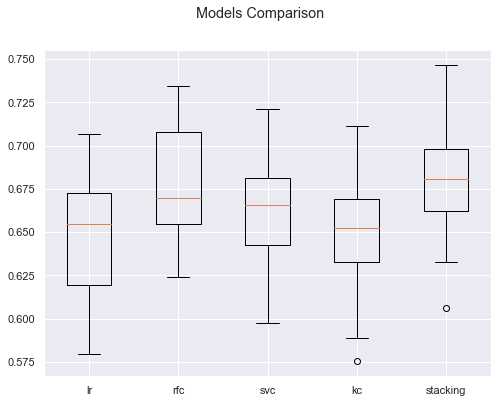

In [51]:
# Boxplot Accuracy
sns.set(rc={'figure.figsize':(8,6)})
fig = plt.figure()
fig.suptitle('Models Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

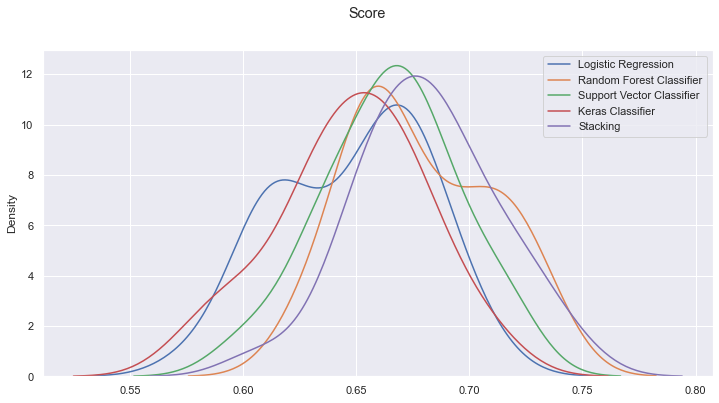

In [52]:
# Plot Accuracy - Fitting of Frequency
sns.set(rc={'figure.figsize':(12,6)})
fig = plt.figure()
fig.suptitle('Score')
ax0 = sns.distplot(results[0],hist=False, label="Logistic Regression")
ax1 = sns.distplot(results[1],hist=False, label="Random Forest Classifier")
ax2 = sns.distplot(results[2],hist=False, label="Support Vector Classifier")
ax3 = sns.distplot(results[3],hist=False, label="Keras Classifier")
ax4 = sns.distplot(results[4],hist=False, label="Stacking")
plt.legend()
plt.show()

## RESULTS

Here the predicted versus actual portfolio returns   

In [53]:
summary = pd.DataFrame(columns=['pred_lr','pred_rfc','pred_svc','pred_kc','pred_stacking'])

summary['pred_lr'] = y_pred_lr
summary['pred_rfc'] = y_pred_rfc
summary['pred_svc'] = y_pred_svc
summary['pred_kc'] = y_pred_kc
summary['pred_stacking'] = y_pred_stacking

In [54]:
symbol = pd.DataFrame(X_test.index.values)
symbol.columns = ['symbol']
summary = summary.join(symbol)
summary = summary.set_index('symbol')

In [55]:
actual = pd.DataFrame(y_test)
actual.columns = ['actual']
summary = summary.merge(actual, left_on=['symbol'], right_on=['symbol'])

In [56]:
DATA_RAW = pd.read_csv('DATA_RAW_2019.csv')
DATA_RAW = DATA_RAW.set_index('symbol')

In [57]:
summary = summary.merge(DATA_RAW['return'], left_on=['symbol'], right_on=['symbol'])

In [58]:
summary

,pred_lr,pred_rfc,pred_svc,pred_kc,pred_stacking,actual,return
symbol,,,,,,,
MFG,0,0,1,0,0,0,-12.76
FF,1,0,1,0,1,1,40.44
STRS,0,0,0,0,0,0,-17.69
CERN,1,1,1,1,1,1,7.77
FARM,0,0,1,0,0,0,-68.06
...,...,...,...,...,...,...,...
QNST,0,1,1,0,1,1,41.71
ANDE,0,1,1,0,1,1,1.94
EGLE,1,1,1,0,1,0,-39.82


In [59]:
p_l = pd.DataFrame(columns=['p/l_lr','p/l_rfc','p/l_svc','p/l_kc','p/l_stacking', 'p/l_actual'])
p_l['p/l_lr'] = summary['pred_lr'] * summary['return']
p_l['p/l_rfc'] = summary['pred_rfc'] * summary['return']
p_l['p/l_svc'] = summary['pred_svc'] * summary['return']
p_l['p/l_kc'] = summary['pred_kc'] * summary['return']
p_l['p/l_stacking'] = summary['pred_stacking'] * summary['return']
p_l['p/l_actual'] = summary['actual'] * summary['return']

In [60]:
p_l

,p/l_lr,p/l_rfc,p/l_svc,p/l_kc,p/l_stacking,p/l_actual
symbol,,,,,,
MFG,-0.00,-0.00,-12.76,-0.00,-0.00,-0.00
FF,40.44,0.00,40.44,0.00,40.44,40.44
STRS,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
CERN,7.77,7.77,7.77,7.77,7.77,7.77
FARM,-0.00,-0.00,-68.06,-0.00,-0.00,-0.00
...,...,...,...,...,...,...
QNST,0.00,41.71,41.71,0.00,41.71,41.71
ANDE,0.00,1.94,1.94,0.00,1.94,1.94
EGLE,-39.82,-39.82,-39.82,-0.00,-39.82,-0.00


In [61]:
p_l.describe()

,p/l_lr,p/l_rfc,p/l_svc,p/l_kc,p/l_stacking,p/l_actual
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,17.287876,18.926836,17.702942,16.897633,19.172389,27.637190
std,58.344538,60.425828,57.473513,57.610549,59.394708,60.211392
min,-193.020000,-78.810000,-74.910000,-193.020000,-74.910000,-0.000000
25%,0.000000,0.000000,-1.380000,0.000000,-0.000000,-0.000000
50%,-0.000000,0.000000,0.000000,-0.000000,0.000000,3.505000
75%,22.730000,23.040000,23.932500,22.730000,24.245000,28.352500
max,720.050000,720.050000,720.050000,720.050000,720.050000,720.050000


In [62]:
# Check results in line with models scores
for col in p_l:
    print('%s: %.3f' % (col, p_l[col].mean()/p_l['p/l_actual'].mean()))

p/l_lr: 0.626
p/l_rfc: 0.685
p/l_svc: 0.641
p/l_kc: 0.611
p/l_stacking: 0.694
p/l_actual: 1.000


## PREDICTIONS WITH DATA 2020

What if one was to use these models with 2020 annual data to make decisions about what stock to buy and hold for 2021? Here below the results of this analysis with a comparison of the portfolios with the indeces S&P and DW

In [63]:
# Import and clean Data upon which the model has to be used for predicting the shares purchase
data_raw = pd.read_csv('DATA_RAW_2020.csv')
data_raw = data_raw.set_index('symbol')

data_clean = data_raw[data_raw.isnull().sum(axis=1) < 10] # Remove Symbol if number of null greater than 10
data_clean['sector'] = data_clean['sector'].fillna('unknown') # Fill null sector with unknown

# Replace Sector Name with a numeric code (Same used for model valuation)
data_clean['sector'].replace({"Basic Materials": "0", 
                              "Industrials": "1", 
                              "Consumer Cyclical": "2", 
                              "Technology": "3", 
                              "Real Estate": "4", 
                              "Healthcare": "5", 
                              "Financial Services": "6", 
                              "Consumer Defensive": "7", 
                              "Utilities": "8", 
                              "Communication Services": "9", 
                              "Energy": "10", 
                              "Pharmaceuticals": "11",
                              "unknown": "12"}, inplace=True)

data_clean = data_clean.rename(columns = {'sector': 'sector_code'}, inplace = False)
data_clean["sector_code"] = pd.to_numeric(data_clean["sector_code"])

X_2020 = data_clean.apply(lambda x: x.fillna(x.mean()))

# Standardize DATA (with exception of sector_code)
for col in X_2020:
    if col != 'sector_code':
        X_2020[col] = (X_2020[col] - X_2020[col].mean())/X_2020[col].std()

X_2020 = X_2020.apply(lambda x: x.fillna(0)) # There maight be columns with all NaN, set to 0

In [64]:
# Get Adj Closing Price for sample symbols
symbol = X_2020.index.tolist()

date = pd.date_range(start='2021-01-01', end='2021-05-31')
prices = pd.DataFrame(date)
prices.columns = ['Date']
prices = prices.set_index('Date')

for i in tqdm(symbol):
    try:
        price = data.DataReader(i, 'yahoo', '2021-01-01', '2021-05-31')['Adj Close']
        df_temp = pd.DataFrame(price)
        df_temp.columns = [i]
        prices = prices.merge(df_temp, left_on=['Date'], right_on=['Date'])
        del df_temp
    except:
        pass

100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


In [65]:
# Predictions (1 buy, 0 ignore) and save into a df
pred_lr = lr.predict(X_2020)
pred_rfc = rfc.predict(X_2020)
pred_svc = svc.predict(X_2020)
pred_kc = kc.predict(X_2020)
pred_stacking = stacking.predict(X_2020)

pred_lr = pd.DataFrame(pred_lr)
pred_rfc = pd.DataFrame(pred_rfc)
pred_svc = pd.DataFrame(pred_svc)
pred_kc = pd.DataFrame(pred_kc)
pred_stacking = pd.DataFrame(pred_stacking)

In [66]:
# Portfolio based on Logistic Regression
pred_lr['symbol']=symbol
pred_lr.columns = ['pred', 'symbol']
pred_lr = pred_lr[(pred_lr['pred'] == 1)]
pred_lr = pred_lr['symbol'].tolist() #List of Symbol 
DATA_LR = prices.drop(columns=[col for col in prices if col not in pred_lr]) # Drop Columns which are not in the list

In [67]:
# Portfolio based on Random Forest Classifier
pred_rfc['symbol']=symbol
pred_rfc.columns = ['pred', 'symbol']
pred_rfc = pred_rfc[(pred_rfc['pred'] == 1)]
pred_rfc = pred_rfc['symbol'].tolist() #List of Symbol 
DATA_RFC = prices.drop(columns=[col for col in prices if col not in pred_rfc]) # Drop Columns which are not in the list

In [68]:
# Portfolio based on Support Vector Classifier
pred_svc['symbol']=symbol
pred_svc.columns = ['pred', 'symbol']
pred_svc = pred_svc[(pred_svc['pred'] == 1)]
pred_svc = pred_svc['symbol'].tolist() #List of Symbol 
DATA_SVC = prices.drop(columns=[col for col in prices if col not in pred_svc]) # Drop Columns which are not in the list

In [69]:
# Portfolio based on Keras Classifier
pred_kc['symbol']=symbol
pred_kc.columns = ['pred', 'symbol']
pred_kc = pred_kc[(pred_kc['pred'] == 1)]
pred_kc = pred_kc['symbol'].tolist() #List of Symbol 
DATA_KC = prices.drop(columns=[col for col in prices if col not in pred_kc]) # Drop Columns which are not in the list

In [70]:
# Portfolio based on Stacking Model
pred_stacking['symbol']=symbol
pred_stacking.columns = ['pred', 'symbol']
pred_stacking = pred_stacking[(pred_stacking['pred'] == 1)]
pred_stacking = pred_stacking['symbol'].tolist() #List of Symbol 
DATA_STACKING = prices.drop(columns=[col for col in prices if col not in pred_stacking]) # Drop Columns which are not in the list

In [71]:
# Cumulative Return Logistic Regression Portfolio
DATA_LR_RETURN = DATA_LR.pct_change()
DATA_LR_RETURN_CUM = DATA_LR_RETURN.cumsum()
DATA_LR_RETURN_CUM['average'] = DATA_LR_RETURN_CUM.mean(axis=1)

In [72]:
# Cumulative Return Random Forest Portfolio
DATA_RFC_RETURN = DATA_RFC.pct_change()
DATA_RFC_RETURN_CUM = DATA_RFC_RETURN.cumsum()
DATA_RFC_RETURN_CUM['average'] = DATA_RFC_RETURN_CUM.mean(axis=1)

In [73]:
# Cumulative Return Support Vector Portfolio
DATA_SVC_RETURN = DATA_SVC.pct_change()
DATA_SVC_RETURN_CUM = DATA_SVC_RETURN.cumsum()
DATA_SVC_RETURN_CUM['average'] = DATA_SVC_RETURN_CUM.mean(axis=1)

In [74]:
# Cumulative Return Keras Portfolio
DATA_KC_RETURN = DATA_KC.pct_change()
DATA_KC_RETURN_CUM = DATA_KC_RETURN.cumsum()
DATA_KC_RETURN_CUM['average'] = DATA_KC_RETURN_CUM.mean(axis=1)

In [75]:
# Cumulative Return Stacking Portfolio
DATA_STACKING_RETURN = DATA_STACKING.pct_change()
DATA_STACKING_RETURN_CUM = DATA_STACKING_RETURN.cumsum()
DATA_STACKING_RETURN_CUM['average'] = DATA_STACKING_RETURN_CUM.mean(axis=1)

In [76]:
# S&P and DW
sp = data.DataReader('^GSPC', 'yahoo', '2021-01-01', '2021-05-31')['Adj Close']
dj = data.DataReader('^DJI', 'yahoo', '2021-01-01', '2021-05-31')['Adj Close']

df_sp = pd.DataFrame(sp)
df_sp.columns = ['S&P']
df_dj = pd.DataFrame(dj)
df_dj.columns = ['DW']

MKT_IND = df_sp.merge(df_dj, left_on=['Date'], right_on=['Date'])
MKT_IND_RETURN = MKT_IND.pct_change()
MKT_IND_RETURN_CUM = MKT_IND_RETURN.cumsum()

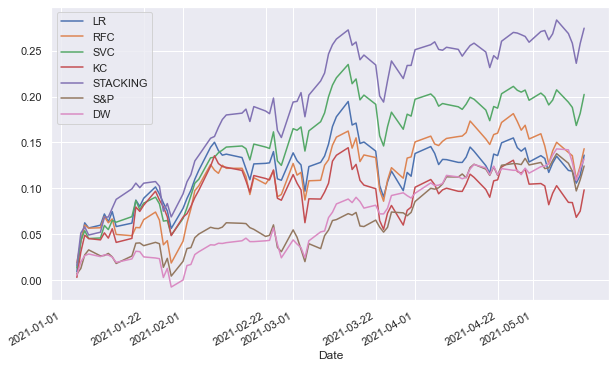

In [83]:
profit = pd.DataFrame(columns=['LR','RFC','SVC','KC','STACKING','S&P','DW'])
profit['LR'] = DATA_LR_RETURN_CUM['average']
profit['RFC'] = DATA_RFC_RETURN_CUM['average']
profit['SVC'] = DATA_SVC_RETURN_CUM['average']
profit['KC'] = DATA_KC_RETURN_CUM['average']
profit['STACKING'] = DATA_STACKING_RETURN_CUM['average']
profit['S&P'] = MKT_IND_RETURN_CUM['S&P']
profit['DW'] = MKT_IND_RETURN_CUM['DW']

profit.plot(figsize=(10, 6));

In [81]:
summary = profit.loc[['2021-01-29', '2021-02-26','2021-03-29','2021-04-30','2021-05-14']]*100
annualised = (((1 + summary.loc['2021-04-30']/100)**3)-1)*100
summary.loc['Annualised P/L'] = annualised
nr_of_stocks = (len(DATA_LR.columns),
                len(DATA_RFC.columns),
                len(DATA_SVC.columns),
                len(DATA_KC.columns),
                len(DATA_STACKING.columns),'n/a','n/a')
summary.loc['Nr Of Stocks'] = nr_of_stocks
summary

,LR,RFC,SVC,KC,STACKING,S&P,DW
Date,,,,,,,
2021-01-29 00:00:00,5.643416,1.882880,4.919655,4.863423,6.900226,0.460129,-0.731729
2021-02-26 00:00:00,10.888311,9.340212,12.507475,8.716351,15.538930,3.11107,2.44861
2021-03-29 00:00:00,9.759628,11.114029,16.440857,6.011939,21.959710,7.34385,9.52597
2021-04-30 00:00:00,12.878946,15.380041,19.593012,10.463503,25.910974,12.5528,11.6631
2021-05-14 00:00:00,13.621005,14.321710,20.230565,9.841352,27.439682,12.4372,13.2022
Annualised P/L,43.826474,53.600302,71.047768,34.789617,99.613885,42.5833,39.2288
Nr Of Stocks,19.000000,13.000000,34.000000,16.000000,23.000000,n/a,n/a
